Importing Libraries

In [1]:
import tensorflow as tf

In [2]:
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

GPU found


In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf

import numpy as np
import os

np.random.seed(42)
tf.random.set_seed(42)

Reading Datasets

In [5]:
with open('./Data/words.txt') as file:
    
    lines=file.readlines()
lines

['#--- words.txt ---------------------------------------------------------------#\n',
 '#\n',
 '# iam database word information\n',
 '#\n',
 '# format: a01-000u-00-00 ok 154 1 408 768 27 51 AT A\n',
 '#\n',
 '#     a01-000u-00-00  -> word id for line 00 in form a01-000u\n',
 '#     ok              -> result of word segmentation\n',
 '#                            ok: word was correctly\n',
 '#                            er: segmentation of word can be bad\n',
 '#\n',
 '#     154             -> graylevel to binarize the line containing this word\n',
 '#     1               -> number of components for this word\n',
 '#     408 768 27 51   -> bounding box around this word in x,y,w,h format\n',
 '#     AT              -> the grammatical tag for this word, see the\n',
 '#                        file tagset.txt for an explanation\n',
 '#     A               -> the transcription for this word\n',
 '#\n',
 'a01-000u-00-00 ok 154 408 768 27 51 AT A\n',
 'a01-000u-00-01 ok 154 507 766 213 48 NN M

Dataset Splitting

In [6]:
base_path = "Data"
words_list = []

words = open(f"{base_path}/words.txt", "r").readlines()
for line in words:
  if line[0] =="#":
    continue
  if line.split(" ")[1] != "err":
    words_list.append(line)

len(words_list)

np.random.shuffle(words_list)

In [7]:
print(words_list[0:10])


['e04-030-04-08 ok 170 1489 1499 120 39 JJ sure\n', 'k02-102-05-03 ok 182 836 1623 69 52 PP3A he\n', 'a01-082u-01-04 ok 172 1582 1043 234 88 IN during\n', 'm01-000-07-00 ok 196 339 1998 75 107 INO of\n', 'g01-031-07-06 ok 152 1912 2038 167 59 NN booty\n', 'f07-081b-01-06 ok 168 1366 924 350 88 NN gastronomy\n', 'n03-082-04-03 ok 165 992 1414 118 135 NN boy\n', 'g06-018c-04-05 ok 182 1298 1438 96 58 ATI The\n', 'g06-011j-06-06 ok 182 1222 1785 146 95 CC and\n', 'f04-024-01-06 ok 183 1104 981 60 70 IN in\n']


In [8]:
split_idx = int(0.9*len(words_list))
train_samples = words_list[:split_idx]
test_samples = words_list[split_idx:]

val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

assert len(words_list) == len(train_samples) + len(validation_samples) + len(test_samples)

print(f"Total Training Samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")


Total Training Samples: 86810
Total validation samples: 4823
Total test samples: 4823


Data input pipeline

In [9]:
base_image_path = os.path.join(base_path, "words")
print(base_path)
def get_image_paths_and_labels(samples):
  paths = []
  corrected_samples = []
  for (i, file_line) in enumerate(samples):
    line_split = file_line.strip()
    line_split = line_split.split(" ")

    # Each line split willl have this format for the the corresponding image:
    # part1/part1-part2/part1-part2-part3.png
    image_name = line_split[0]
    partI = image_name.split("-")[0]
    partII = image_name.split("-")[1]
    img_path = os.path.join(
        base_image_path, partI, partI + "-" + partII, image_name + ".png"
    )
    if os.path.getsize(img_path):
      paths.append(img_path)
      corrected_samples.append(file_line.split("\n")[0])

  return paths, corrected_samples

train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)

Data


Testing Data input Pipeline

In [10]:
base_image_path = os.path.join(base_path, "test_imgs")
print(base_image_path)

t_images = []
from os import listdir
from os.path import isfile, join

# onlyfiles = [f for f in listdir(base_image_path) if isfile(join(base_image_path, f))]
for f in listdir(base_image_path):
  t_images_path = os.path.join(base_image_path, f)
  t_images.append(t_images_path)

print(t_images)

Data\test_imgs
['Data\\test_imgs\\line0word0.jpg', 'Data\\test_imgs\\line0word1.jpg', 'Data\\test_imgs\\line0word2.jpg', 'Data\\test_imgs\\line0word3.jpg', 'Data\\test_imgs\\line0word4.jpg', 'Data\\test_imgs\\line10word0.jpg', 'Data\\test_imgs\\line10word1.jpg', 'Data\\test_imgs\\line1word0.jpg', 'Data\\test_imgs\\line1word1.jpg', 'Data\\test_imgs\\line1word2.jpg', 'Data\\test_imgs\\line1word3.jpg', 'Data\\test_imgs\\line1word4.jpg', 'Data\\test_imgs\\line1word5.jpg', 'Data\\test_imgs\\line1word6.jpg', 'Data\\test_imgs\\line1word7.jpg', 'Data\\test_imgs\\line2word0.jpg', 'Data\\test_imgs\\line2word1.jpg', 'Data\\test_imgs\\line2word2.jpg', 'Data\\test_imgs\\line2word3.jpg', 'Data\\test_imgs\\line2word4.jpg', 'Data\\test_imgs\\line2word5.jpg', 'Data\\test_imgs\\line2word6.jpg', 'Data\\test_imgs\\line3word0.jpg', 'Data\\test_imgs\\line3word1.jpg', 'Data\\test_imgs\\line3word2.jpg', 'Data\\test_imgs\\line3word3.jpg', 'Data\\test_imgs\\line3word4.jpg', 'Data\\test_imgs\\line3word5.jpg', 'D

In [11]:
t_images[0:10]

['Data\\test_imgs\\line0word0.jpg',
 'Data\\test_imgs\\line0word1.jpg',
 'Data\\test_imgs\\line0word2.jpg',
 'Data\\test_imgs\\line0word3.jpg',
 'Data\\test_imgs\\line0word4.jpg',
 'Data\\test_imgs\\line10word0.jpg',
 'Data\\test_imgs\\line10word1.jpg',
 'Data\\test_imgs\\line1word0.jpg',
 'Data\\test_imgs\\line1word1.jpg',
 'Data\\test_imgs\\line1word2.jpg']

In [12]:
# Sorting string list with numbers

import re

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

# alist=[
#     "something1",
#     "something12",
#     "something17",
#     "something2",
#     "something25",
#     "something29"]

t_images.sort(key=natural_keys)
print(t_images)

['Data\\test_imgs\\line0word0.jpg', 'Data\\test_imgs\\line0word1.jpg', 'Data\\test_imgs\\line0word2.jpg', 'Data\\test_imgs\\line0word3.jpg', 'Data\\test_imgs\\line0word4.jpg', 'Data\\test_imgs\\line1word0.jpg', 'Data\\test_imgs\\line1word1.jpg', 'Data\\test_imgs\\line1word2.jpg', 'Data\\test_imgs\\line1word3.jpg', 'Data\\test_imgs\\line1word4.jpg', 'Data\\test_imgs\\line1word5.jpg', 'Data\\test_imgs\\line1word6.jpg', 'Data\\test_imgs\\line1word7.jpg', 'Data\\test_imgs\\line2word0.jpg', 'Data\\test_imgs\\line2word1.jpg', 'Data\\test_imgs\\line2word2.jpg', 'Data\\test_imgs\\line2word3.jpg', 'Data\\test_imgs\\line2word4.jpg', 'Data\\test_imgs\\line2word5.jpg', 'Data\\test_imgs\\line2word6.jpg', 'Data\\test_imgs\\line3word0.jpg', 'Data\\test_imgs\\line3word1.jpg', 'Data\\test_imgs\\line3word2.jpg', 'Data\\test_imgs\\line3word3.jpg', 'Data\\test_imgs\\line3word4.jpg', 'Data\\test_imgs\\line3word5.jpg', 'Data\\test_imgs\\line4word0.jpg', 'Data\\test_imgs\\line4word1.jpg', 'Data\\test_imgs\\l

In [13]:
train_img_paths[0:10]

['Data\\words\\e04\\e04-030\\e04-030-04-08.png',
 'Data\\words\\k02\\k02-102\\k02-102-05-03.png',
 'Data\\words\\a01\\a01-082u\\a01-082u-01-04.png',
 'Data\\words\\m01\\m01-000\\m01-000-07-00.png',
 'Data\\words\\g01\\g01-031\\g01-031-07-06.png',
 'Data\\words\\f07\\f07-081b\\f07-081b-01-06.png',
 'Data\\words\\n03\\n03-082\\n03-082-04-03.png',
 'Data\\words\\g06\\g06-018c\\g06-018c-04-05.png',
 'Data\\words\\g06\\g06-011j\\g06-011j-06-06.png',
 'Data\\words\\f04\\f04-024\\f04-024-01-06.png']

In [14]:
train_labels[0: 10]

['e04-030-04-08 ok 170 1489 1499 120 39 JJ sure',
 'k02-102-05-03 ok 182 836 1623 69 52 PP3A he',
 'a01-082u-01-04 ok 172 1582 1043 234 88 IN during',
 'm01-000-07-00 ok 196 339 1998 75 107 INO of',
 'g01-031-07-06 ok 152 1912 2038 167 59 NN booty',
 'f07-081b-01-06 ok 168 1366 924 350 88 NN gastronomy',
 'n03-082-04-03 ok 165 992 1414 118 135 NN boy',
 'g06-018c-04-05 ok 182 1298 1438 96 58 ATI The',
 'g06-011j-06-06 ok 182 1222 1785 146 95 CC and',
 'f04-024-01-06 ok 183 1104 981 60 70 IN in']

Then we prepare the groung-truth labels
# find maximum length and the size of the vocabulary in the training data.


In [15]:
train_labels_cleaned = []
characters = set()
max_len = 0

for label in train_labels:
  label = label.split(" ")[-1].strip()
  for char in label:
    characters.add(char)

  max_len = max(max_len, len(label))
  train_labels_cleaned.append(label)

print("Maximum length: ", max_len)
print("Vocab size: ", len(characters))

# Check some label samples
train_labels_cleaned[:10]

Maximum length:  21
Vocab size:  78


['sure',
 'he',
 'during',
 'of',
 'booty',
 'gastronomy',
 'boy',
 'The',
 'and',
 'in']

Now we clean the validation and the test labels as well

In [16]:
def clean_labels(labels):
  cleaned_labels = []
  for label in labels:
    label = label.split(" ")[-1].strip()
    cleaned_labels.append(label)
  return cleaned_labels

validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)

In [18]:
ff = list(characters)

In [19]:
import pickle
file = "my character.pkl"
fileobj = open(file, 'wb')
pickle.dump(ff, fileobj)
fileobj.close()

In [20]:
import pickle
file = "my character.pkl"
fileobj = open(file, 'rb')
b = pickle.load(fileobj)
print(b)

['K', 'e', 'A', 'q', 'r', '2', '#', 'p', '?', '4', 't', ';', 'f', '8', ',', 'F', ':', 'X', 'g', '+', 'L', 'z', 'B', 'l', '0', '/', 'T', 'u', 'C', '1', 'w', 'E', 'V', '.', 'j', 'h', '"', 's', 'k', 'm', 'R', 'J', 'y', 'I', 'O', 'P', '&', 'M', '5', 'i', 'N', 'Q', 'b', '!', ')', 'n', 'v', '(', 'c', 'H', 'o', '6', 'Y', '-', '*', '7', '3', "'", 'D', 'Z', 'W', 'S', 'a', 'U', 'd', '9', 'G', 'x']


Building the character vocabulary

In [21]:
from tensorflow.keras.layers.experimental.preprocessing import StringLookup

In [22]:
AUTOTUNE = tf.data.AUTOTUNE

# Maping characaters to integers
char_to_num = StringLookup(vocabulary=b, mask_token=None)

#Maping integers back to original characters
num_to_chars = StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)


Resizing images without distortion
Instead of square images, many OCR models work with rectangular images. This will become clearer in a moment when we will visualize a few ‘samples from the dataset. While aspect-unaware resizing square images does not introduce a significant amount of distortion this is not the case for rectangular images. But resizing images to a uniform size is a requirement for mini-batching. So we need to perform our resizing such that the following criteria are met:

Aspect ratio is preserved.

Content of the images is not affected

In [25]:
def distortion_free_resize(image, img_size):
  w, h = img_size
  image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

  # Check tha amount of padding needed to be done.
  pad_height = h - tf.shape(image)[0]
  pad_width = w - tf.shape(image)[1]

  # only necessary if you want to do same amount of padding on both sides.
  if pad_height % 2 != 0:
    height = pad_height // 2
    pad_height_top = height +1
    pad_height_bottom = height
  else:
    pad_height_top = pad_height_bottom = pad_height // 2

  if pad_width % 2 != 0:
    width = pad_width // 2
    pad_width_left = width + 1
    pad_width_right = width
  else:
    pad_width_left = pad_width_right = pad_width // 2

  image = tf.pad(
      image, paddings=[
          [pad_height_top, pad_height_bottom],
          [pad_width_left, pad_width_right],
          [0, 0],
      ],
  )
  image = tf.transpose(image, perm=[1,0,2])
  image = tf.image.flip_left_right(image)
  return image

if we just go witht the plain resizing then the images would look like so:
putting the utilities together

In [26]:
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32

def preprocess_image(image_path, img_size=(image_width, image_height)):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_png(image, 1)
  image = distortion_free_resize(image, img_size)
  image = tf.cast(image, tf.float32) / 255.0
  return image

def vectorize_label(label):
  label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
  length = tf.shape(label)[0]
  pad_amount = max_len - length
  label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
  return label

 
def process_images_labels(image_path, label):
  image = preprocess_image(image_path)
  label = vectorize_label(label)
  return {"image": image, "label": label}
  
def prepare_dataset(image_paths, labels):
  dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
    process_images_labels, num_parallel_calls=AUTOTUNE
  )

  return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)


Prepare tf.data.Dataset objects

In [27]:
train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)


Preparing new inference/testing images

In [28]:
# Testing inference images
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32

def preprocess_image(image_path, img_size=(image_width, image_height)):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_png(image, 1)
  image = distortion_free_resize(image, img_size)
  image = tf.cast(image, tf.float32) / 255.0
  return image

def process_images_2(image_path):
  image = preprocess_image(image_path)
  # label = vectorize_label(label)
  return {"image": image}
  
def prepare_test_images(image_paths):
  dataset = tf.data.Dataset.from_tensor_slices((image_paths)).map(
    process_images_2, num_parallel_calls=AUTOTUNE
  )

  # return dataset
  return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

inf_images = prepare_test_images(t_images)
     

Visualize new test images

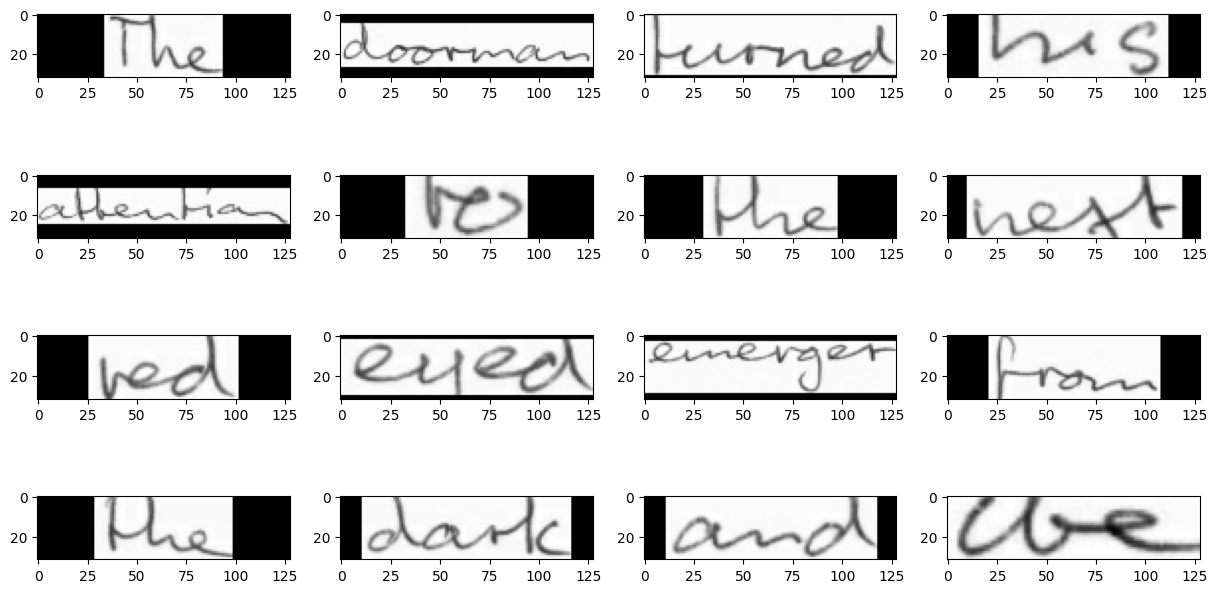

In [29]:
# Visualize test images 

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

for data in inf_images.take(1):
  images = data["image"]
  # imm = images.reshape(images.shape[0], (images.shape[1]*images.shape[2]))
  # imm = imm.transpose()
  # print(imm.shape)
  _, ax = plt.subplots(4, 4, figsize=(15, 8))

  # ss = plt.imshow(imm, cmap="gray")
  # plt.show()
  for i in range(16): 
    img = images[i]
    # print(img.shape)
    img = tf.image.flip_left_right(img)
    img = tf.transpose(img, perm=[1, 0, 2])
    img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
    img = img[:, :, 0]

    # Gather indices where Label!= padding token

    ax[i // 4, i % 4].imshow(img, cmap="gray")
    

  plt.show()

Visualize few samples

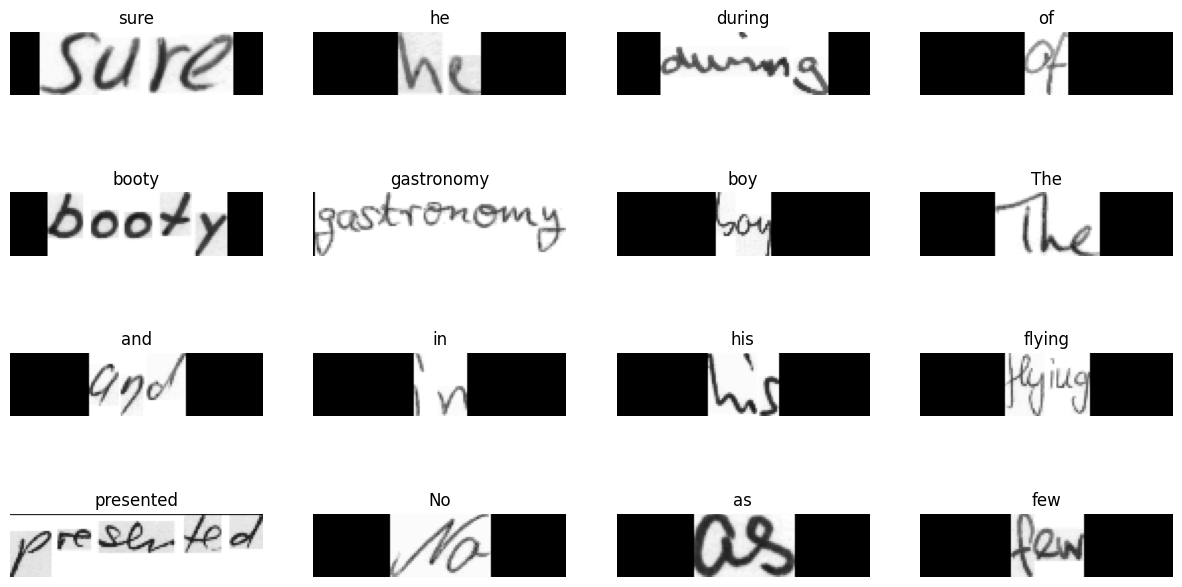

In [30]:
for data in train_ds.take(1):
  images, labels = data["image"], data["label"]
  _, ax = plt.subplots(4, 4, figsize=(15, 8))

  for i in range(16): 
    img = images[i]
    # print(img.shape)
    img = tf.image.flip_left_right(img)
    img = tf.transpose(img, perm=[1, 0, 2])
    img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
    img = img[:, :, 0]

    # Gather indices where Label!= padding token
    label = labels[i]
    indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
    # Convert to string.
    label = tf.strings.reduce_join(num_to_chars(indices))
    label = label.numpy().decode("utf-8")

    ax[i // 4, i % 4].imshow(img, cmap="gray")
    ax[i // 4, i % 4].set_title(label)
    ax[i // 4, i % 4].axis("off")

  plt.show()


Model
Model uses CTC loss as an endpoint layer.

In [31]:
class CTCLayer(keras.layers.Layer):

  def __init__(self, name=None):
    super().__init__(name=name)
    self.loss_fn = keras.backend.ctc_batch_cost

  def call(self, y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    loss = self.loss_fn(y_true, y_pred, input_length, label_length)
    self.add_loss(loss)

    # At test time, just return the computed predictions.
    return y_pred

def build_model():
  input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
  labels = keras.layers.Input(name="label", shape=(None,))

  # first conv block
  x = keras.layers.Conv2D(
      32, (3,3), activation = "relu",
      kernel_initializer="he_normal",
      padding="same",
      name="Conv1"
  )(input_img)
  x = keras.layers.MaxPooling2D((2,2), name="pool1")(x)

  # Second conv block
  x = keras.layers.Conv2D(
      64, (3,3), activation = "relu", kernel_initializer="he_normal",
      padding="same",
      name="Conv2"
  )(x)
  x = keras.layers.MaxPooling2D((2,2), name="pool2")(x)

  # We have two maxpool layers with pool size and strides 2
  # Hence downsampled feature maps are 4x smaller the number of filters in the last layer is 64, 
  # Reshape accordingly before passing the output to the RNN part of the model.
  
  new_shape = ((image_width // 4), (image_height // 4) * 64)
  x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
  x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
  x = keras.layers.Dropout(0.2)(x)

  # RNN
  x = keras.layers.Bidirectional(
      keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
  )(x)
  x = keras.layers.Bidirectional(
    keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
  )(x)
  # +2 is to account for the two special tokens introduced by the CTC loss.
  # The recommendation comes here: https://git.10/J0eXP.
  x = keras.layers.Dense(
    len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
  )(x)
  # Add CTC layer for calculating CTC Loss at each step.
  output = CTCLayer(name="ctc_loss")(labels, x)

  # Define the model.
  model = keras.models.Model(
      inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
  )
  
  # optimizer
  opt = keras.optimizers.Adam()
  # Compile the model and return
  model.compile(optimizer=opt)
  return model

# Get the model
model = build_model()
model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 128, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 32, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 64, 16, 32)   0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 64, 16, 64)   18496       ['pool1[0][0

Evaluation Metrix

In [32]:

# Edit Distance is the most widely used metric for evaluating OCR models. In this section, we will implement it and use it as a callback to monitor
# ‘our model.

# We first segregate the validation images and their labels for convenience.

validation_images = []
validation_labels = []

for batch in validation_ds:
  validation_images.append(batch["image"])
  validation_labels.append(batch["label"])


Now we create a callback to monitor the edit distance

In [33]:
def calculate_edit_distance(labels, predictions):
  # Get a single batch and convert its labels to sparse tensors.
  sparse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

  # Make predictions and convert them to sparse tensors.
  input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
  predictions_decoded = keras.backend.ctc_decode(
    predictions, input_length=input_len, greedy=True
  )[0][0][:, :max_len]
  sparse_predictions = tf.cast(
    tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
  )

  # Compute individual edit distances and average them out.
  edit_distances = tf.edit_distance(
    sparse_predictions, sparse_labels, normalize=False
  )
  return tf.reduce_mean(edit_distances)

class EditDistanceCallback(keras.callbacks.Callback):
  def __init__(self, pred_model):
    super().__init__()
    self.prediction_model = pred_model
  def on_epoch_end(self, epoch, logs = None):
    edit_distances = []

    for i in range(len(validation_images)):
      labels = validation_labels[i]
      predictions = self.prediction_model.predict(validation_images[i])
      edit_distances.append(calculate_edit_distance(labels, predictions).numpy())
    print(f"Mean eidt distance for each {epoch + 1}: {np.mean(edit_distances): .4f}")

Training

In [35]:
# Now we are ready to kick off model training,

epochs = 10 # To get good results this should be at least 50.

model = build_model()
prediction_model = keras.models.Model(
  model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
edit_distance_callback = EditDistanceCallback(prediction_model)

# Train the model.
history = model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=epochs,
  callbacks=[edit_distance_callback],
)

Epoch 1/10
1/1 [==============================] - 17s 17s/step
Mean eidt distance for each 1:  20.4338
1357/1357 [==============================] - 1149s 834ms/step - loss: 13.5161 - val_loss: 11.8114
Epoch 2/10
1/1 [==============================] - 0s 53ms/step
Mean eidt distance for each 2:  20.0737
1357/1357 [==============================] - 739s 540ms/step - loss: 10.5418 - val_loss: 9.5199
Epoch 3/10
1/1 [==============================] - 0s 75ms/step
Mean eidt distance for each 3:  19.7115
1357/1357 [==============================] - 540s 398ms/step - loss: 8.7585 - val_loss: 7.5674
Epoch 4/10
1/1 [==============================] - 0s 78ms/step
Mean eidt distance for each 4:  18.7914
1357/1357 [==============================] - 603s 445ms/step - loss: 7.1113 - val_loss: 5.6885
Epoch 5/10
1/1 [==============================] - 0s 78ms/step
Mean eidt distance for each 5:  18.4163
1357/1357 [==============================] - 453s 334ms/step - loss: 5.7743 - val_loss: 4.6238
Epoch 

Saving thje model
Below is working saved models

In [63]:
model.save_weights('E:\Projects\handwritten_text_recognizier\ocr_model_v4.h5')
prediction_model.save_weights('E:\Projects\handwritten_text_recognizier\ocr_model_v5.h5')


model.save("E:\Projects\handwritten_text_recognizier\/ocr_model_v8.h5")
prediction_model.save("E:\Projects\handwritten_text_recognizier\ocr_model_50_epoch.h5")

Inferences

(64, 128, 32, 1)
2/2 [==============================] - 1s 38ms/step


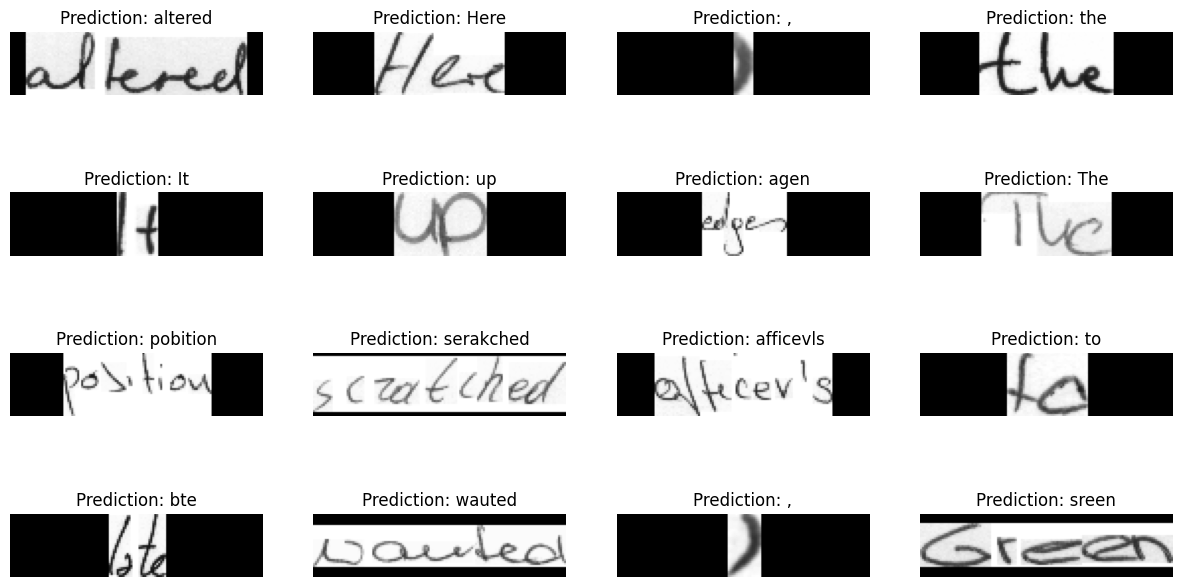

In [64]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]

    # Iterate over the results and get back the text.
    output_text = []

    for res in results:
      res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
      res = tf.strings.reduce_join(num_to_chars(res)).numpy().decode("utf-8")
      output_text.append(res)

    return output_text


# Let's check results on sone test samples.
for batch in test_ds.take(1):
    batch_images = batch["image"]
    print(batch_images.shape)

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
      img = batch_images[i]
      img = tf.image.flip_left_right(img)
      img = tf.transpose(img, perm=[1, 0, 2])
      img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
      img = img[:, :, 0]

      title = f"Prediction: {pred_texts[i]}"
      ax[i // 4, i % 4].imshow(img, cmap = "gray")
      ax[i // 4, i % 4].set_title(title)
      ax[i // 4, i % 4].axis("off")

    plt.show()

# THE END

Inference on New set of images

In [66]:
custom_objects = {"CTCLayer": CTCLayer}

E:\Projects\handwritten_text_recognizier\ocr_model_50_epoch.h5

In [67]:
reconstructed_model = keras.models.load_model("E:\Projects\handwritten_text_recognizier\ocr_model_50_epoch.h5", custom_objects=custom_objects)
     

In [68]:
prediction_model = keras.models.Model(
  reconstructed_model.get_layer(name="image").input, reconstructed_model.get_layer(name="dense2").output
)

Inference on New set of images

(64, 128, 32, 1)
2/2 [==============================] - 11s 27ms/step


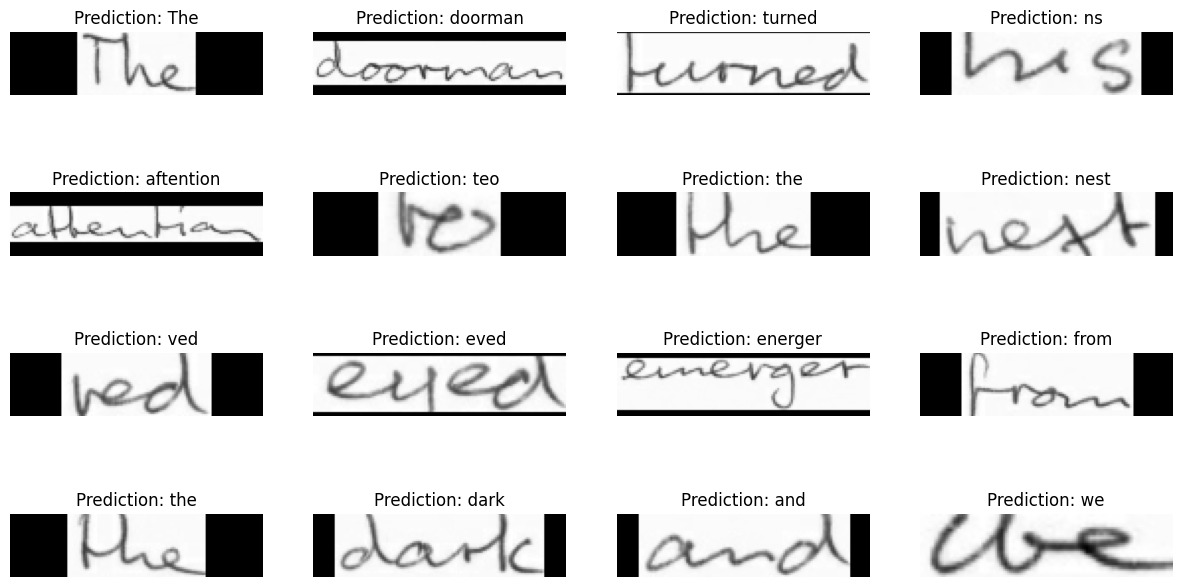

(18, 128, 32, 1)
1/1 [==============================] - 4s 4s/step


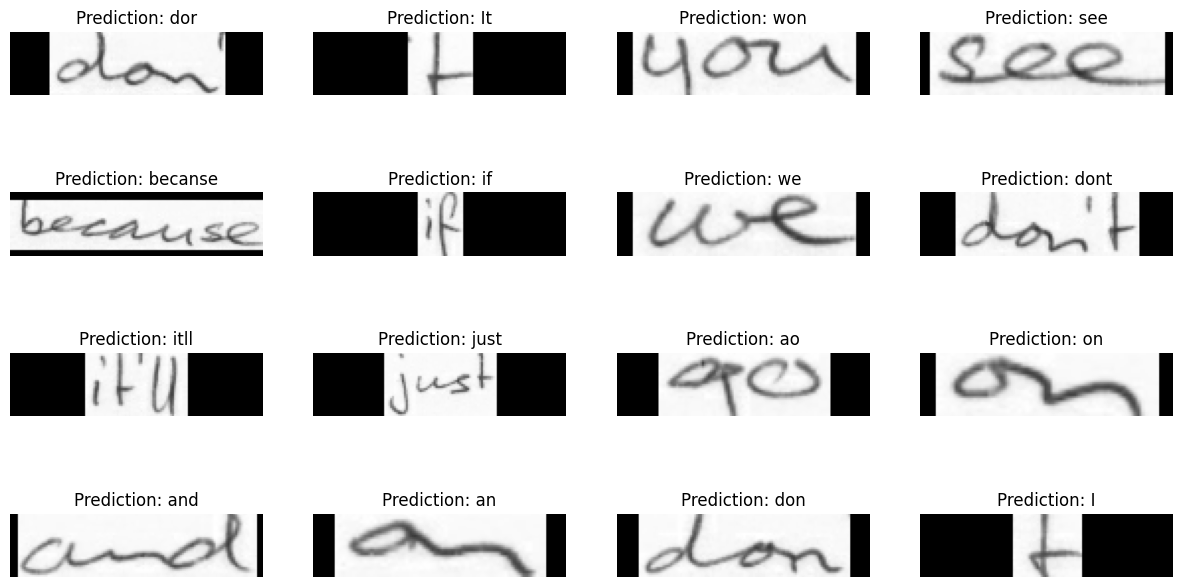

In [69]:
# Inference on New set of images
pred_test_text = []

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]

    # Iterate over the results and get back the text.
    output_text = []

    for res in results:
      res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
      res = tf.strings.reduce_join(num_to_chars(res)).numpy().decode("utf-8")
      output_text.append(res)

    return output_text


# Let's check results on sone test samples.
for batch in inf_images.take(3):
    batch_images = batch["image"]
    # batch_images= tf.expand_dims(batch_images, axis=0)
    print(batch_images.shape)
    # print(batch_images.shape)

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)
    pred_test_text.append(pred_texts)

    for i in range(16):
      img = batch_images[i]
      img = tf.image.flip_left_right(img)
      img = tf.transpose(img, perm=[1, 0, 2])
      img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
      img = img[:, :, 0]

      title = f"Prediction: {pred_texts[i]}"
      ax[i // 4, i % 4].imshow(img, cmap = "gray")
      ax[i // 4, i % 4].set_title(title)
      ax[i // 4, i % 4].axis("off")

    plt.show()

In [70]:
for batch in inf_images:
    batch_images = batch["image"]
    batch_images= tf.expand_dims(batch_images, axis=0)
    print(batch_images.shape)

(1, 64, 128, 32, 1)
(1, 18, 128, 32, 1)


In [71]:
flat_list = [item for sublist in pred_test_text for item in sublist]
print(flat_list)

['The', 'doorman', 'turned', 'ns', 'aftention', 'teo', 'the', 'nest', 'ved', 'eved', 'energer', 'from', 'the', 'dark', 'and', 'we', 'went', 'an', 'tooether', 'to', 'the', 'station', 'the', 'children', 'eilent', 'because', 'of', 'the', 'snelty', 'of', 'the', 'world', 'Finaly', 'Catherine', 'sad', 'her', 'eger', 'wet', 'agan', 'think', 'its', 'all', 'abotutely', 'beasttyy', 'and', 'I', 'can', 'It', 'bear', 'tothink', 'sbout', 'it', 'And', 'D', 'hilip', 'sad', 'But', 'me', 'he', 'aot', 'to', 'think', 'about', 'it', 'dor', 'It', 'won', 'see', 'becanse', 'if', 'we', 'dont', 'itll', 'just', 'ao', 'on', 'and', 'an', 'don', 'I', 'non', 'see']


In [72]:
sentence = ' '.join(flat_list)
print(sentence)

The doorman turned ns aftention teo the nest ved eved energer from the dark and we went an tooether to the station the children eilent because of the snelty of the world Finaly Catherine sad her eger wet agan think its all abotutely beasttyy and I can It bear tothink sbout it And D hilip sad But me he aot to think about it dor It won see becanse if we dont itll just ao on and an don I non see
